**Paul Pontisso & Timon Ther**

# eXtreme MultiLabel (XML) Classification

Une tâche de classification est dite "extrême" dès lors que le nombre de classes considérées devient très important (de quelques dizaines à plusieurs millions). L'appellation "Multilabel" désigne quant à elle une classification où chaque échantillon ("sample") peut avoir plus d'une catégorie ; tous les échantillons ne sont d'ailleurs pas nécessairement associés au même nombre de catégories.

Dans ce notebook, nous allons montrer pourquoi ce problème ne peut pas être raisonnablement approché de façon naïve, puis justifier et mettre en place une méthode basée sur l'article [**Deep Extreme Multi-label Learning**](https://arxiv.org/pdf/1704.03718.pdf) par Zhang et al.

In [1]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

# Théorie : le problème de l'indépendance des labels

Le problème de classification multi-label est différent du problème multi-classe.

En effet, le problème multi-classe consiste à adresser l'unique classe la plus probable pour un point (par exemple la reconnaissance d'objet sur une image avec un seul objet par image)
Le problème multi-label consiste à adresser le sous ensemble des classes le plus probable ( par exemple la reconnaissance d'objet sur une image avec la possibilité d'avoir plusieurs objets sur une même image)

De premier abord, on pourrait penser que les classes les plus probables individuellement constituent le sous ensemble le plus probable.
Ceci est vrai seulement si la probabilité d'apparition d'une classe est indépendante des autres classes, c'est a dire si $P(A\,|\, B) = P(A) $, avec A et B deux classes de notre problème.
On ne peut pas raisonnablement considérer cette indépendance dans tous les cas. Le meilleur sous ensemble de classes n'est donc pas forcément la réunion des meilleures classes.

Le problème multi-label est donc beaucoup plus complexe car le nombre de sous ensembles de classes est beaucoup plus grand que le nombre de classes, de l'ordre de $2^N $, avec N le nombre de classes. Pour 20 classes, on a un peu plus d'1 millions de sous ensembles, et pour 100 classes, on a $ 1,26 . 10^{30}$ sous ensembles de classes possibles.

# Un exemple : reconnaissance des chants d'oiseaux

Ce set de données représentatives d'enregistrements audio vise à savoir quelles espèces d'oiseaux (parmi 19 considérées) peut-on entendre sur chaque enregistrement. Il est relativement court, c'est-à-dire qu'il y a peu de données, ce qui rend une approche de type réseau de neurones peu viable.

Les données ont été utilisées ici : [The 9th annual MLSP competition: New methods for acoustic classification of multiple simultaneous bird species in a noisy environment]( http://vintage.winklerbros.net/Publications/mlsp2013ma.pdf ).

In [2]:
# Récupérer les données
X_train, X_test = np.loadtxt('X_train_birds.txt'), np.loadtxt('X_test_birds.txt')
y_train, y_test = np.loadtxt('y_train_birds.txt'), np.loadtxt('y_test_birds.txt')
birds_list = ["Brown Creeper","Pacific Wren","Pacific-slope Flycatcher","Red-breasted Nuthatch",
              "Dark-eyed Junco","Olive-sided Flycatcher","Hermit Thrush","Chestnut-backed Chickadee",
              "Varied Thrush","Hermit Warbler","Swainson's Thrush","Hammond's Flycatcher",
              "Western Tanager","Black-headed Grosbeak","Golden Crowned Kinglet","Warbling Vireo",
              "MacGillivray's Warbler","Stellar's Jay","Common Nighthawk"]

<div class="alert alert-warning">Observez et commentez les données : vérifiez qu'il s'agit bien d'un problème multi-label.
Quels problèmes pourraient se présenter si l'on appliquait une méthode globale "à l'aveugle" ?</div>

In [3]:
# CORRECTION
print(len(X_train), ' échantillons de training et ', len(X_test), ' échantillons de test')
print('###')
for i in range(len(birds_list)):
    print(' Espèce {} recensée {} fois'.format(birds_list[i], np.sum(y_train[:,i]) + np.sum(y_test[:,i])))
print('###')
all_y = np.concatenate([y_train, y_test])
all_sum_y = np.sum(all_y, axis=1)
print('En moyenne {} espèces sont présentes sur chaque enregistrement (écart-type {})'.format(np.mean(all_sum_y), np.std(all_sum_y)))

# Remarquons que la répartition selon les espèces est très inégale. Cela aurait tendance à induire un biais
# si l'on appliquait une méthode black-box de façon brutale sur l'ensemble des données, comme par exemple
# un réseau de neurones

322  échantillons de training et  323  échantillons de test
###
 Espèce Brown Creeper recensée 14.0 fois
 Espèce Pacific Wren recensée 81.0 fois
 Espèce Pacific-slope Flycatcher recensée 46.0 fois
 Espèce Red-breasted Nuthatch recensée 9.0 fois
 Espèce Dark-eyed Junco recensée 20.0 fois
 Espèce Olive-sided Flycatcher recensée 14.0 fois
 Espèce Hermit Thrush recensée 47.0 fois
 Espèce Chestnut-backed Chickadee recensée 40.0 fois
 Espèce Varied Thrush recensée 61.0 fois
 Espèce Hermit Warbler recensée 53.0 fois
 Espèce Swainson's Thrush recensée 103.0 fois
 Espèce Hammond's Flycatcher recensée 28.0 fois
 Espèce Western Tanager recensée 33.0 fois
 Espèce Black-headed Grosbeak recensée 9.0 fois
 Espèce Golden Crowned Kinglet recensée 37.0 fois
 Espèce Warbling Vireo recensée 17.0 fois
 Espèce MacGillivray's Warbler recensée 6.0 fois
 Espèce Stellar's Jay recensée 10.0 fois
 Espèce Common Nighthawk recensée 26.0 fois
###
En moyenne 1.013953488372093 espèces sont présentes sur chaque enregis

<div class="alert alert-warning"> (Facultatif) Implémentez un classificateur MLP (Multi-Layer Perceptron) pour vérifier la difficulté de la tâche.</div>

In [4]:
# CORRECTION 1 : SKLEARN
mlpc = MLPClassifier(hidden_layer_sizes=(64,32,32), activation='relu')
mlpc.fit(X_train, y_train)
mlpc.score(X_test, y_test), mlpc.score(X_train, y_train)

(0.44272445820433437, 0.44099378881987578)

In [5]:
# CORRECTION 2 : KERAS

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

mlpk = Sequential()
mlpk.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
mlpk.add(Dense(32, activation='relu'))
mlpk.add(Dense(len(birds_list), activation='tanh'))

mlpk.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=Adam())

h = mlpk.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=0)

Using TensorFlow backend.


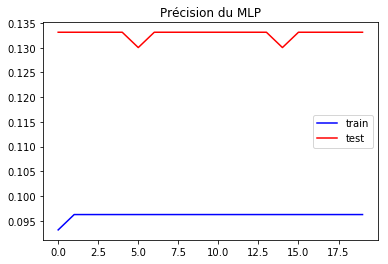

In [6]:
# CORRECTION
plt.figure()
plt.plot(h.history['categorical_accuracy'], c='blue', label='train')
plt.plot(h.history['val_categorical_accuracy'], c='red', label='test')
plt.legend(loc='best')
plt.title('Précision du MLP')
plt.show()

In [7]:
# CORRECTION
# Définitivement, les MLP ne sont pas très probants !

# Baseline : classificateurs parallèles

<div class="alert alert-warning">L'approche intuitive (que vous savez désormais inexacte !) : prédisez individuellement chaque label (utilisez par exemple des classificateurs Bayesiens naïf). </div>

In [8]:
# CORRECTION
classif_list = []
train_score_list, test_score_list = [], []

# Training
for i in range(len(birds_list)):
    y_train_for_this_bird = y_train[:,i]
    new_classifier = GaussianNB()
    new_classifier.fit(X_train, y_train_for_this_bird)
    classif_list.append(new_classifier)

# Test & display results
for i in range(len(birds_list)):
    classif = classif_list[i]
    train_score = float('{0:.3f}'.format(classif.score(X_train, y_train[:,i])))
    test_score = float('{0:.3f}'.format(classif.score(X_test, y_test[:,i])))
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    print('Detecting {} with {}% accuracy (training {}%)'.format(birds_list[i], 100*test_score, 100*train_score))

predict_train = np.zeros_like(y_train)
predict_test = np.zeros_like(y_test)
for i in range(len(birds_list)):
    classif = classif_list[i]
    predict_train[:,i] = classif.predict(X_train)
    predict_test[:,i] = classif.predict(X_test)
acc_train = 1 - np.sum(np.abs(predict_train - y_train))/(y_train.shape[0]*y_train.shape[1])
acc_test = 1 - np.sum(np.abs(predict_test - y_test))/(y_test.shape[0]*y_test.shape[1])
print('###')
print('Global accuracy: testing {}, training {}'.format(acc_test, acc_train))

well_labeled = 0
for i in range(len(y_train)):
    if np.sum(np.abs(y_train[i,:] - predict_train[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} training samples were well labeled'.format(well_labeled,len(y_train)))

well_labeled = 0
for i in range(len(y_test)):
    if np.sum(np.abs(y_test[i,:] - predict_test[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(y_test)))

# Evidemment, en plus d'être mathématiquement désapprouvée, cette méthode est encombrante:
# imaginez avoir à construire un million de classificateurs ! Ce n'est pas du tout extensible à de la classification extrême

Detecting Brown Creeper with 69.3% accuracy (training 73.9%)
Detecting Pacific Wren with 62.5% accuracy (training 62.4%)
Detecting Pacific-slope Flycatcher with 80.5% accuracy (training 78.60000000000001%)
Detecting Red-breasted Nuthatch with 97.8% accuracy (training 98.8%)
Detecting Dark-eyed Junco with 65.3% accuracy (training 64.0%)
Detecting Olive-sided Flycatcher with 92.30000000000001% accuracy (training 91.0%)
Detecting Hermit Thrush with 79.60000000000001% accuracy (training 80.10000000000001%)
Detecting Chestnut-backed Chickadee with 84.5% accuracy (training 86.0%)
Detecting Varied Thrush with 63.2% accuracy (training 62.4%)
Detecting Hermit Warbler with 73.1% accuracy (training 75.2%)
Detecting Swainson's Thrush with 60.699999999999996% accuracy (training 68.60000000000001%)
Detecting Hammond's Flycatcher with 49.2% accuracy (training 51.6%)
Detecting Western Tanager with 70.0% accuracy (training 64.9%)
Detecting Black-headed Grosbeak with 94.69999999999999% accuracy (trainin

<div class="alert alert-info">La classification Multi - Label et sa version XL , l'eXtreme MultiLabel Classification (XML) sont des problèmes difficiles à traiter sur lesquels les méthodes classiques ne peuvent pas être utilisées telles quelles.</div>

# Principe de l'embedding

L'embedding est une technique qui consiste à projeter des vecteurs dans un autre espace.
On projette les vecteurs dans un espace de dimension plus petite, avec des vecteurs denses (pas de zéro).
Cela à pour intéret principal de créer des relations entre les différents points qui étaient invisibles avant.

L'embedding est surtout utilisé dans le cas de vecteurs avec une très grande dimension et beaucoup de zéros (dits 'sparse').

Par exemple :

<table>
    <tr>
        <td></td>
        <td>Chien</td>
        <td>Chat</td>
        <td>Eléphant</td>
        <td>Tortue</td>
        <td>Lapin</td>
    </tr>
    <tr>
        <td>Chien</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>Chat</td>
        <td>0</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
    </tr>
    <tr>
        <td>Lapin</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>1</td>
    </tr>
</table>

<table>
    <tr>
        <td></td>
        <td>D1</td>
        <td>D2</td>
        <td>D3</td>
        <td>D4</td>
    </tr>
    <tr>
        <td>Chien</td>
        <td>0.123</td>
        <td>0.452</td>
        <td>0.865</td>
        <td>0.852</td>
    </tr>
    <tr>
        <td>Chat</td>
        <td>0.458</td>
        <td>0.741</td>
        <td>0.852</td>
        <td>0.963</td>
    </tr>
    <tr>
        <td>Lapin</td>
        <td>0.789</td>
        <td>0.456</td>
        <td>0.845</td>
        <td>0.654</td>
    </tr>
</table>

Par exemple, l'embedding sur les mots permet de créer des relations de compositions. Par exemple, on peut avoir la relation suivante sur les vecteurs représentant les différents mots dans le nouvel espace crée : Roi - Homme + Femme = Reine. Cette technique est donc très utile pour les tâches d'apprentissage du langage qui nécessitent une représentation du lexique tels que de la traduction.

Dans l'exemple utilisé dans ce notebook, les relations de ce genre ne sont pas aussi explicites (en tout cas pour les humains !) mais peuvent toutefois être utilisées par l'algorithme afin d'enrichir ses repères.

# Méhode de Zhang et Al : l'Embedding pour la prise en compte de l'interaction entre les labels

L'algorithme de deep extreme multi-label Learning est basé sur deux phases d'apprentissage, une phase sur les features et une phase sur les labels.

### Première étape : recherche de l'adjacence des labels

Nous commençons par créer la matrice ainsi que le graphe d'adjacence des labels.

Chaque noeud représente un label et il existe une arête entre deux noeuds si il existe au moins un échantillon pour lequel les deux labels apparaissent.

<img src="./images/labelmatrix.png" alt="image matrice d'adjacence" style="width: 700px;"/>

### Seconde étape : apprentissage sur les labels pour l'Embedding

L'article cité ci-dessus utilise l'algorithme DeepWalk pour projeter les labels dans un espace réduit et sans zéros. Deepwalk n'est ni plus ni moins qu'un embedding clé-en-main pour graphes.

Dans notre exemple, nous utiliserons une technique moins efficace mais beaucoup plus simple a implémenter, qui constituera en une simple projection linéaire.

### Troisième étape : prédiction dans l'espace continu et retour aux labels

La troisième étape consiste à entrainer un réseau de neurones sur le nouvel espace des labels. La fonction de perte est donc représentée par la norme 2 dans le nouvel espace réduit des labels || x' - y'||. y' représente les labels dans l'espace réduit et x la prédiction de l'algorithme dans cet espace.

(Dans notre exemple, nous ne conseillons pas l'usage d'un réseau de neurones car le nombre d'échantillons est très faible, mais toute méthode de régression multidimensionnelle fait l'affaire.)

La conversion depuis notre espace réduit vers l'espace des labels est relativement simple. Etant donné un échantillon à classifier, on effectue une recherche k-NN ( k-Nearest Neighbors) dans l'espace de dimension réduite des caractéristiques afin de trouver des échantillons similaires.
La somme des labels des k voisins les plus proches sont renvoyés comme étant la prédiction.

Schéma récapitulatif : 

<img src="./images/schema1.png" alt="Image schéma recapitulatif" style="width: 700px;"/>


## Mise en pratique de la méthode sur notre exemple

### Construction de la matrice d'adjacence

<div class="alert alert-warning"> La méthode étudiée est basée sur la proximité des labels. Construisez la matrice de proximité des labels $M_{[i,j] \in [|1,19|]^2}$ telle que $m_{i,j}$ soit la fréquence d'apparition simultanée des labels $i$ et $j$.</div>

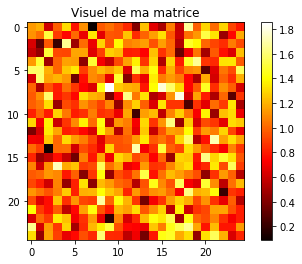

In [9]:
# ASTUCE
# Visualiser une matrice 19*19 n'est pas forcément évident.
# Vous trouverez ci-dessous une méthode toute simple pour représenter
# une matrice comme une image.

my_matrix = np.random.normal(loc=1, scale=0.3, size=(25,25)) # matrice à représenter
plt.figure()
plt.imshow(my_matrix,cmap="hot")
plt.colorbar()
plt.title('Visuel de ma matrice')
plt.show()

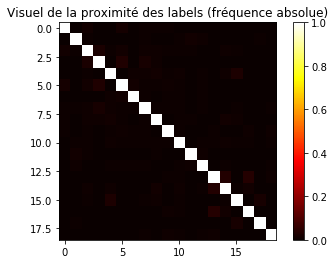

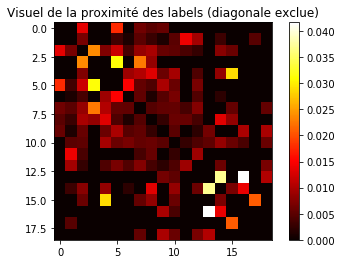

In [10]:
# CORRECTION
# Création de la matrice de correspondance des labels
# on en profite pour créer une liste de couples de labels reliés (utile pour la construction du graphe à venir)

matrix = np.zeros((y_train.shape[1],y_train.shape[1]))
edges =[]
for row in y_train : # On prend les points d'entrainements un par un
    for i in range(len(row)):
        for j in range(len(row)):
            
            if row[i]*row[j] == 1: #Si les deux labels sont présents 
                matrix[i,j] += 1
                if ([i,j] not in edges) and ([j,i] not in edges) and not i==j:
                    edges.append([i,j])

# Pour normaliser en fréquence, on peut diviser chaque ligne/colonne par le coefficient de la diagonale correspondate (i,i)
norm_matrix = np.copy(matrix)
for i in range(matrix.shape[0]):
    d = norm_matrix[i,i]
    norm_matrix[:,i] = norm_matrix[:,i]/d
    norm_matrix[i,:] = norm_matrix[i,:]/d
    norm_matrix[i,i] = 1

#Visualiser
plt.figure()
plt.imshow(norm_matrix,cmap="hot")
plt.colorbar()
plt.title('Visuel de la proximité des labels (fréquence absolue)')
plt.show()

# Si l'on veut raffiner les nuances, on peut tricher en réduisant les coefficients diagonaux, qui ne nous intéressent de toute façon pas
norm_matrix -= np.identity(norm_matrix.shape[0])
plt.figure()
plt.imshow(norm_matrix,cmap="hot")
plt.colorbar()
plt.title('Visuel de la proximité des labels (diagonale exclue)')
plt.show()

### Construction du graphe d'adjacence

Une autre façon de se représenter la proximité entre les labels est de construire un graphe pondéré. C'est nécessaire pour Zhang et al, qui utilisent ce graphe pour leur embedding, mais le nôtre ne nécessitera que la matrice d'adjacence. Nous vous conseillons de construire ce graphe *a minima* dans une optique de visualisation des données.


Nous mettons à votre disposition la fonction **draw_graph** qui permettra de construire automatiquement celui-ci à partir d'une liste de labels connectés et de la matrice de proximité que vous venez de calculer. L'option *threshold* vous permet de choisir à partir de combien d'occurence un lien sera représenté sur le graphe.

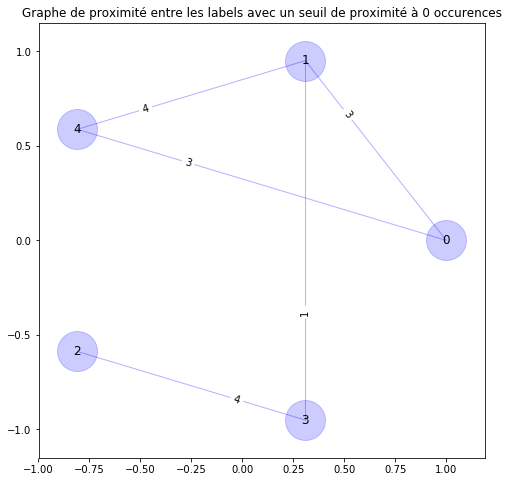

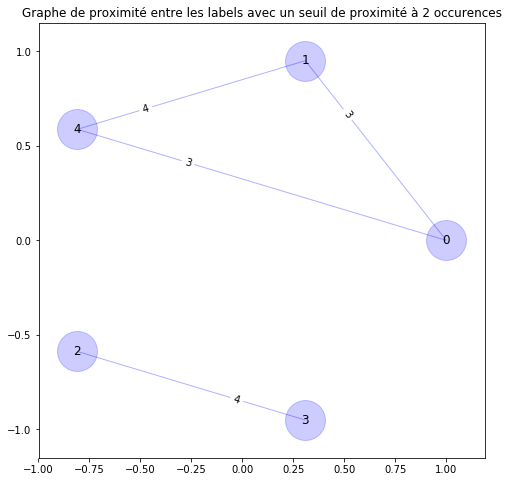

In [11]:
import networkx as nx # Cette librairie est incluse dans la distribution Anaconda

def draw_graph(edges, weights_matrix=None, threshold=0, figsize=(8,8)):
    
    '''
    edges : liste des labels connectés
    weights_matrix : matrice de proximité des labels
    threshold : seuil à partir duquel on affiche le lien sur le graphe (en nombre d'occurences')
    figsize : taille de la figure qui sera affichée
    '''
    
    edges = [edge for edge in edges if weights_matrix[edge[0],edge[1]] > threshold]
    
    # additional settings (you can mess around here)
    node_size = 1600
    node_color = 'blue'
    node_alpha = 0.2
    node_text_size = 12
    edge_color = 'blue'
    edge_alpha= 0.3
    edge_tickness = 1
    edge_text_pos = 0.3
    text_font = 'sans-serif'

    plt.figure(figsize=figsize)
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in edges:
        G.add_edge(edge[0], edge[1])

    # select shell autolocation
    graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,
                           graph_pos,
                           node_size=node_size, 
                           alpha=node_alpha,
                           node_color=node_color)
    nx.draw_networkx_edges(G, graph_pos,width=edge_tickness, alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size, font_family=text_font)
    
    # construct weights dict
    weights={}
    for i in range(len(edges)):
        weights[tuple(edges[i])] = weights_matrix.astype(int)[edges[i][0],edges[i][1]]
    
    # draw weights
    edge_labels = weights
    nx.draw_networkx_edge_labels(G, graph_pos, edge_labels=edge_labels, 
                                 label_pos=edge_text_pos)

    # show graph
    plt.title('Graphe de proximité entre les labels avec un seuil de proximité à {} occurences'.format(threshold))
    plt.show()

# Exemple
graph = [(0, 1), (1, 4), (2, 3), (0, 4), (1, 3)]
weights_matrix = np.random.randint(1,high=5,size=(5,5))
draw_graph(graph,weights_matrix)
draw_graph(graph,weights_matrix, threshold=2)

<div class="alert alert-warning"> (Facultatif) Construisez le graphe associé aux données au seuil qui vous paraît pertinent</div>

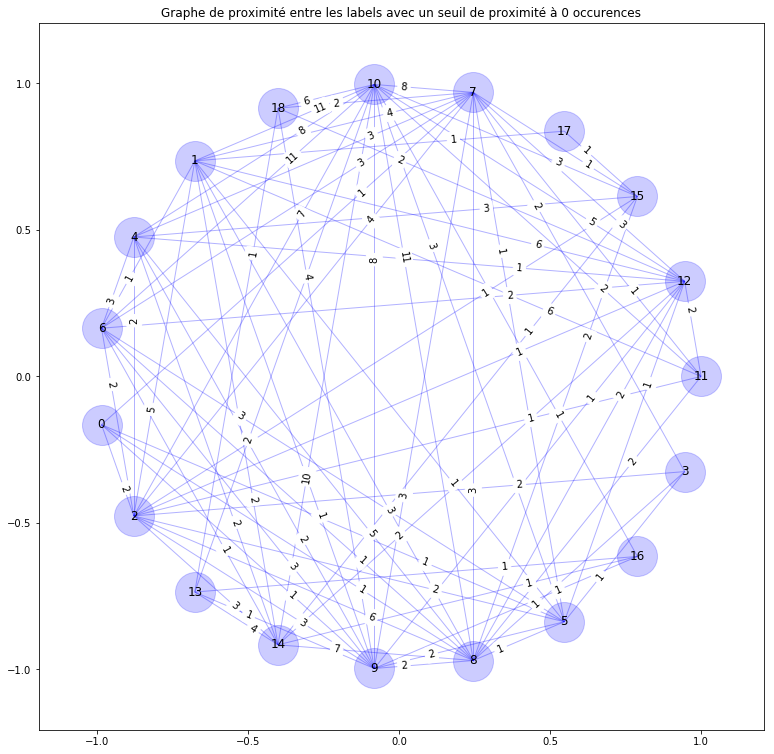

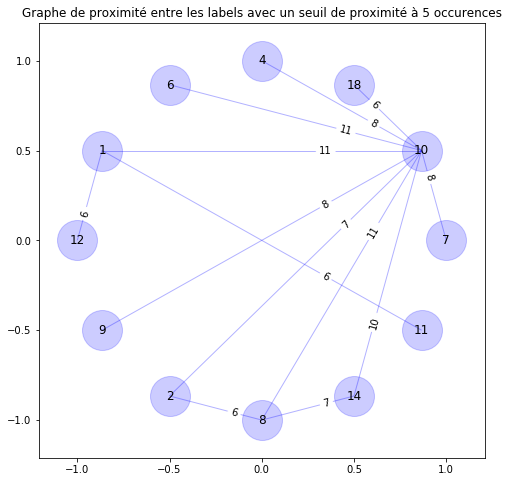

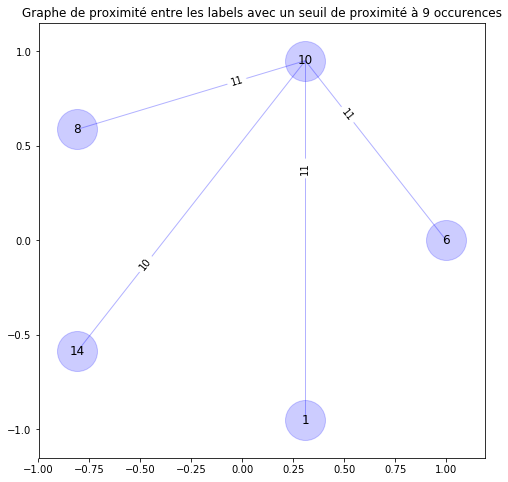

In [12]:
# CORRECTION

draw_graph(edges, matrix, figsize=(13,13), threshold=0)
draw_graph(edges, matrix, figsize=(8,8), threshold=5)
draw_graph(edges, matrix, figsize=(8,8), threshold=9)

## Mise en place de l'Embedding

Une fois le graphe construit, Zhang et al utilisent [**Deepwalk**](https://github.com/phanein/deepwalk) pour réduire la dimension de leurs labels, c'est-à-dire les projeter dans un espace *continu* de dimension inférieure.

A notre échelle, nous pouvons nous contenter de faire une simple multiplication de nos vecteurs de labels par la matrice de proximité normalisée que nous avons construite précédemment, ce qui va projeter nos labels dans un espace continu de dimension 19. C'est dans cet espace continu que nous allons faire un apprentissage de régression.


<div class="alert alert-warning"> Pour l'instant, nous allons mettre en place l'Embedding dans cet espace continu. Construisez une fonction **embedding_encode** qui multiplie un ou plusieurs échantillons par la matrice de passage vers l'espace continu (matrice d'adjacence) puis les centre et réduit ; appliquez-la à y_train et y_test. </div>


Par exemple, on souhaite creer une fonction telle que :
f( [ 0,0,0,0,0,0,1,0,0,1 ] ) = [0.25 , 0.32 , 0.87]

In [13]:
# CORRECTION
def embedding_encode(y, matrix, scalor=None, return_scalor=False):
    y_conti = np.dot(y, norm_matrix)
    if scalor:
        y_conti=scalor.transform(y_conti)
    else:
        scalor = StandardScaler()
        y_conti = scalor.fit_transform(y_conti)
    
    if return_scalor:
        return y_conti, scalor
    else:
        return y_conti

y_conti_train, scalor = embedding_encode(y_train, norm_matrix, return_scalor=True)
y_conti_test = embedding_encode(y_test, norm_matrix, scalor=scalor)

<div class="alert alert-warning"> La classe *KneighborsClassifier* que vous pouvez importer depuis *sklearn.neighbors* dispose d'une méthode *kneighbors* qui permet de renvoyer les indices des $n$ voisins les plus proches. Utilisez-la pour créer une méthode **encoding_decode** qui permet de passer d'un échantillon de l'espace continu vers l'espace des labels.</div>

(Si vous préférez implémenter directement ou autrement l'algorithme du KNN, c'est à votre goût !)

Par exemple, on souhaite creer une fonction telle que :
f( [ 0.25 , 0.32 , 0.87 ] ) = [ 0,0,0,0,0,0,1,0,0,1 ]

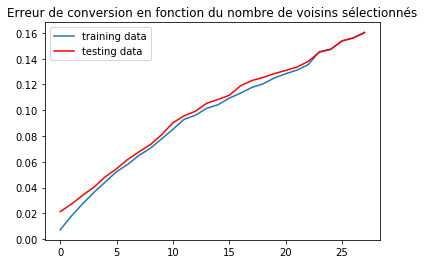

In [14]:
# CORRECTION

knn = KNeighborsClassifier()
knn.fit(y_conti_train, y_train)

def embedding_decode(y, knn, neighbors_number=2, algorithm='brute', y_train=y_train):
    indexes_of_neighbors = knn.kneighbors(y,n_neighbors=neighbors_number, return_distance=False)
    number_of_samples = indexes_of_neighbors.shape[0]
    labels = np.zeros((number_of_samples, y_train.shape[1]))
    
    for i in range(number_of_samples):
        for j in range(neighbors_number):
            labels[i, :] += y_train[indexes_of_neighbors[i,j],:]
        for j in range(labels.shape[1]):
            if labels[i,j]: labels[i,j] = 1
    
    return labels

# small optimization on neighbors_number
err_list=[]
err_list_t=[]
for n in range(2,30):
    y_train_decoded = embedding_decode(y_conti_train, knn, n )
    y_test_decoded = embedding_decode(y_conti_test, knn , n)
    error = np.sum(np.abs(y_train_decoded - y_train))
    error_t = np.sum(np.abs(y_test_decoded - y_test))
    err_list.append(error/(y_train.shape[0]*y_train.shape[1]))
    err_list_t.append(error_t/(y_test.shape[0]*y_test.shape[1]))
plt.figure()
plt.plot(err_list, label='training data')
plt.plot(err_list_t, label='testing data', color='red')
plt.legend(loc='best')
plt.title('Erreur de conversion en fonction du nombre de voisins sélectionnés')
plt.show()

## Régression dans l'espace continu

Nous disposons à présent d'un moyen de passer de l'espace des labels à leur représentation continue et vice-versa, il ne nous reste plus qu'à mettre en oeuvre la régression dans l'espace continu pour boucler la méthode !

<div class="alert alert-warning"> Créez un régresseur (utilisez par exemple RandomForestRegressor) prédisant les valeurs continues (*y_conti*) à partir des features (*X_train, X_test*), puis utilisez la fonction **embedding_decode** codée précedemment pour revenir à l'espace des labels. Comparez la précision obtenue à celle de vos classificateurs parallèles.</div>

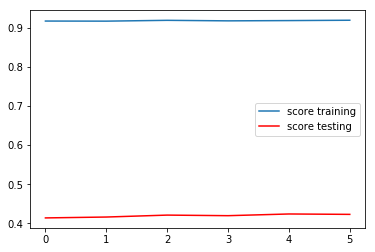

Wall time: 59.4 s


In [15]:
%%time
# CORRECTION

# Cet estimateur est celui qui réalise la véritable "prédiction", une bonne précision est plus que souhaitable
# On réalise donc une mini-optimisation sur le nombre d'arbes de notre Random Forest
list_train, list_test = [],[]
for n in range(100,1101,200):
    regressor = RandomForestRegressor(n_estimators=n, n_jobs=-1)
    regressor.fit(X_train, y_conti_train)
    list_train.append(regressor.score(X_train,y_conti_train))
    list_test.append(regressor.score(X_test,y_conti_test))
plt.figure()
plt.plot(list_train, label='score training')
plt.plot(list_test, label='score testing', color='red')
plt.legend(loc='best')
plt.show()

In [16]:
# CORRECTION

# Faire la régression
regressor = RandomForestRegressor(n_estimators = 400, n_jobs=-1)
regressor.fit(X_train, y_conti_train)
y_conti_predict = regressor.predict(X_test)

In [17]:
# CORRECTION

# Convertir en labels
y_predict = embedding_decode(y_conti_predict, knn)

In [18]:
# CORRECTION

# Evaluer la précision
well_labeled = 0
for i in range(len(y_test)):
    if np.array_equal(y_test[i,:] , y_predict[i,:]):
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(y_test)))

Overall 147 out of the 323 testing samples were well labeled


<div class="alert alert-info">Bien que notre embedding soit réduit à sa plus simple expression et que notre régresseur soit d'une prédiction discutable, la prise en compte de l'adjacence des labels a permis de passer de 24 à 141 échantillons bien classés sur 323 par rapport à notre baseline de 19 naïve-bayes parallèles. La valeur ajoutée de la méthode est incontestable aussi bien sur le plan mathématique que pratique !</div>

La limite principale de la methode est liée à la fonction passant de l'embedding space à l'espace des labels. En effet, la fonction k-Nearest-Neighbors prend comme attribut le nombre de voisins à selectionner. Ce nombre est donc fixe pour tous les échantillons. Cela implique que le même nombre de labels sera prédit pour tous les échantillons.


# Pour aller plus loin

Vous pouvez trouver divers datasets bien plus importants en suivant les liens suivants :
    - http://mulan.sourceforge.net/datasets-mlc.html 
    - http://manikvarma.org/downloads/XC/XMLRepository.html

Vous pourrez expérimenter sur ceux-ci l'embedding à partir du graphe d'adjacence avec [**Deepwalk**](https://github.com/phanein/deepwalk). Vous trouverez le papier expliquant le fonctionnement en détails [**ici**](https://arxiv.org/pdf/1403.6652.pdf)

Deepwalk est un algorithme qui utilise des random walks afin d'apprendre une représentation des noeuds d'un graphe. Deepwalk utilise les informations obtenue après des random walks en considérant les suites de noeuds rencontrés.
Cette methode a un avantage, elle est adaptable. Il n'est pas necessaire de recommencer le processus depuis le début pour ajouter de nouveaux noeuds et relations. 